**SO2 Model**

Mounted at /content/drive
Training model for SO2...
Epoch 1/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6504 - loss: 1.3730 - val_accuracy: 0.9925 - val_loss: 0.1935 - learning_rate: 9.0000e-05
Epoch 2/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9922 - loss: 0.1496 - val_accuracy: 0.9925 - val_loss: 0.0554 - learning_rate: 8.1000e-05
Epoch 3/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9913 - loss: 0.0698 - val_accuracy: 0.9925 - val_loss: 0.0494 - learning_rate: 7.2900e-05
Epoch 4/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9910 - loss: 0.0617 - val_accuracy: 0.9925 - val_loss: 0.0479 - learning_rate: 6.5610e-05
Epoch 5/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9904 - loss: 0.0661 - val_accuracy: 0.9925 - val_loss: 0.0470 - learning_rate: 5.9049e-05
Epoch 6/30
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9928 - loss: 0.0515 - val_accuracy: 0.9925 - val_loss: 0.0464 - learning_rate: 5.3144e-05
Epoch 7/30
2

Test accuracy for SO2 model: 0.9925


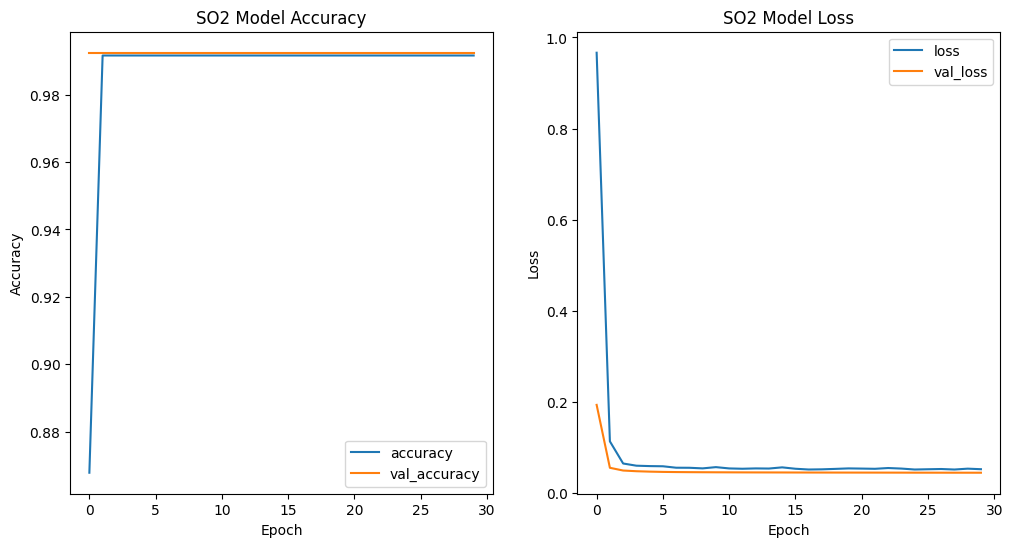

In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt

# If running on Google Colab, mount Google Drive to save and access files
from google.colab import drive
drive.mount('/content/drive')

# File paths for the uploaded files in Colab
csv_file = '/content/MetaData.csv'
zip_file = '/content/ImagesData.zip'
extract_folder = '/content/extracted_images'

# Read the CSV file
data = pd.read_csv(csv_file)

# Remove rows with any missing values
data.dropna(inplace=True)

# Define pollutant level categories for Sulfur Dioxide (SO2)
def categorize_so2(value):
    if value <= 35.0:
        return 0  # Good
    elif value <= 75.0:
        return 1  # Moderate
    elif value <= 185.0:
        return 2  # Unhealthy for Sensitive Groups
    elif value <= 304.0:
        return 3  # Unhealthy
    elif value <= 604.0:
        return 4  # Very Unhealthy
    else:
        return 5  # Hazardous

# Map pollutant levels to categories for SO2
data['SO2_Class'] = data['SO2'].apply(categorize_so2)

# Extract images
if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Set the correct subdirectory for image paths
image_folder = os.path.join(extract_folder, 'ImagesData') + '/'
image_paths = [os.path.join(image_folder, filename.strip()) for filename in data['Filename'].values]

# Function to calculate average RGB values, HSV values, and standard deviation for the top 40% of each image
def calculate_avg_rgb_hsv_std(image_path, crop_fraction=0.4):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # Crop the top 40% of the image
    original_height = tf.shape(image)[0]
    crop_height = tf.cast(tf.cast(original_height, tf.float32) * crop_fraction, tf.int32)
    cropped_image = tf.image.crop_to_bounding_box(image, 0, 0, crop_height, tf.shape(image)[1])

    # Cast the cropped image to float32 before calculating the average
    cropped_image = tf.cast(cropped_image, tf.float32)

    # Calculate the average RGB values
    avg_rgb = tf.reduce_mean(tf.reshape(cropped_image, [-1, 3]), axis=0) / 255.0

    # Calculate the standard deviation of RGB values
    std_rgb = tf.math.reduce_std(tf.reshape(cropped_image, [-1, 3]), axis=0) / 255.0

    # Convert the cropped image to HSV and calculate average HSV values
    cropped_image_hsv = tf.image.rgb_to_hsv(cropped_image / 255.0)
    avg_hsv = tf.reduce_mean(tf.reshape(cropped_image_hsv, [-1, 3]), axis=0)

    return avg_rgb.numpy(), avg_hsv.numpy(), std_rgb.numpy()  # Convert to numpy arrays

# Calculate average RGB, HSV values, and standard deviation, and add them to the DataFrame
r_values, g_values, b_values, h_values, s_values, v_values, std_r_values, std_g_values, std_b_values = [], [], [], [], [], [], [], [], []
for image_path in image_paths:
    avg_rgb, avg_hsv, std_rgb = calculate_avg_rgb_hsv_std(image_path)
    r_values.append(avg_rgb[0])
    g_values.append(avg_rgb[1])
    b_values.append(avg_rgb[2])
    h_values.append(avg_hsv[0])
    s_values.append(avg_hsv[1])
    v_values.append(avg_hsv[2])
    std_r_values.append(std_rgb[0])
    std_g_values.append(std_rgb[1])
    std_b_values.append(std_rgb[2])

data['R'] = r_values
data['G'] = g_values
data['B'] = b_values
data['H'] = h_values
data['S'] = s_values
data['V'] = v_values
data['std_R'] = std_r_values
data['std_G'] = std_g_values
data['std_B'] = std_b_values

# Split the data into training and testing sets for SO2
def split_data():
    labels = data['SO2_Class'].values
    features = data[['R', 'G', 'B', 'H', 'S', 'V', 'std_R', 'std_G', 'std_B']].values  # Using RGB, HSV, and std values
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels, test_size=0.2, random_state=42
    )
    return train_features, test_features, train_labels, test_labels

# Define a more complex neural network model for the extended feature set
def create_rgb_hsv_std_model(num_classes):
    model = models.Sequential([
        layers.Input(shape=(9,)),  # RGB + HSV + std input
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),  # Dropout for regularization
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Adjust learning rate scheduler
def lr_scheduler(epoch, lr):
    return lr * 0.9 if epoch < 10 else lr * 0.95

# Training configuration
def train_model(model, train_features, train_labels, test_features, test_labels, epochs=30, learning_rate=1e-4):
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

    history = model.fit(train_features, train_labels,
                        validation_data=(test_features, test_labels),
                        epochs=epochs,
                        callbacks=[early_stopping, lr_scheduler_callback])

    # Evaluate on the test set after training
    test_loss, test_accuracy = model.evaluate(test_features, test_labels, verbose=2)
    print(f'Test accuracy for SO2 model: {test_accuracy:.4f}')

    return history, test_accuracy

# Train and evaluate the model for SO2
def run_training_for_so2(num_classes):
    print(f"Training model for SO2...")

    # Prepare datasets
    train_features, test_features, train_labels, test_labels = split_data()

    # Create and train model
    model = create_rgb_hsv_std_model(num_classes)
    history, test_accuracy = train_model(model, train_features, train_labels, test_features, test_labels)

    # Save the model
    model.save('SO2_rgb_hsv_std_model.h5')

    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'SO2 Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title(f'SO2 Model Loss')

    plt.show()

# Run training for SO2 (6 classes)
run_training_for_so2(num_classes=6)


**NO2 Model**

Found 8488 validated image filenames.
Found 2122 validated image filenames.
Training enhanced model for NO2 with reduced image size and data generator...
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


266/266 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.3642 - loss: 2.0642 - val_accuracy: 0.7696 - val_loss: 1.4876 - learning_rate: 1.0000e-04
Epoch 2/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.7045 - loss: 1.2879 - val_accuracy: 0.8242 - val_loss: 1.0065 - learning_rate: 9.9911e-05
Epoch 3/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.8027 - loss: 0.9724 - val_accuracy: 0.0999 - val_loss: 3.1865 - learning_rate: 9.9557e-05
Epoch 4/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.8475 - loss: 0.7873 - val_accuracy: 0.8704 - val_loss: 0.7485 - learning_rate: 9.8763e-05
Epoch 5/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - accuracy: 0.8622 - loss: 0.6807 - val_accuracy: 0.8454 - val_loss: 0.6055 - learning_rate: 9.7367e-05
Epoch 6/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.8695 - loss: 0.6059 - val_accuracy: 0.8384 - val_loss: 0.7227 - learning_rate: 9.5222e-05
Epoch 7/100
266/266 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - accuracy

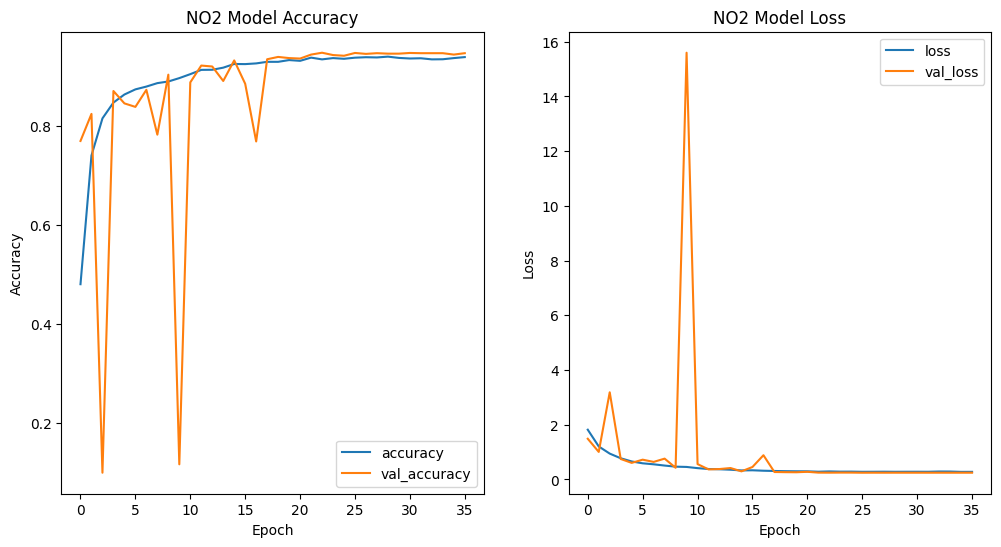

In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
import os

# File paths for the uploaded files in Colab
csv_file = '/content/MetaData.csv'
zip_file = '/content/ImagesData.zip'
extract_folder = '/content/extracted_images'

# Read the CSV file
data = pd.read_csv(csv_file)
data.dropna(inplace=True)

# Define pollutant level categories for Nitrogen Dioxide (NO2)
def categorize_no2(value):
    if value <= 53.0:
        return 0  # Good
    elif value <= 100.0:
        return 1  # Moderate
    elif value <= 360.0:
        return 2  # Unhealthy for Sensitive Groups
    elif value <= 649.0:
        return 3  # Unhealthy
    elif value <= 1249.0:
        return 4  # Very Unhealthy
    else:
        return 5  # Hazardous

# Map pollutant levels to categories for NO2
data['NO2_Class'] = data['NO2'].apply(categorize_no2)

# Extract images if not already extracted
if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Set the correct subdirectory for image paths
image_folder = os.path.join(extract_folder, 'ImagesData') + '/'
image_paths = [os.path.join(image_folder, filename.strip()) for filename in data['Filename'].values]
labels = data['NO2_Class'].values

# Define image target size to reduce memory usage
TARGET_SIZE = (128, 128)  # Smaller resolution to save memory
BATCH_SIZE = 32

# Create ImageDataGenerator for loading and preprocessing images
datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values

def create_image_data_generator(image_paths, labels, batch_size=BATCH_SIZE, target_size=TARGET_SIZE):
    df = pd.DataFrame({'filename': image_paths, 'class': labels})
    generator = datagen.flow_from_dataframe(
        dataframe=df,
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='raw',
        shuffle=True
    )
    return generator

# Create training and testing generators
train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

train_generator = create_image_data_generator(train_image_paths, train_labels)
test_generator = create_image_data_generator(test_image_paths, test_labels)

# Enhanced model architecture for NO2
def create_enhanced_no2_model(num_classes):
    model = models.Sequential([
        layers.Input(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)),  # Image input shape
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Cosine learning rate scheduler
def cosine_decay(epoch, lr):
    initial_learning_rate = lr
    decay_steps = 50
    alpha = 0.1
    cosine_decay = 0.5 * (1 + np.cos(np.pi * epoch / decay_steps))
    decayed = (1 - alpha) * cosine_decay + alpha
    return initial_learning_rate * decayed

# Training configuration with test accuracy evaluation
def train_enhanced_no2_model(model, train_generator, test_generator, epochs=100, learning_rate=1e-4):
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler_callback = LearningRateScheduler(cosine_decay)

    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler_callback]
    )

    # Evaluate on the test set after training
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=2)
    print(f'Test accuracy for enhanced NO2 model: {test_accuracy:.4f}')

    return history, test_accuracy

# Train and evaluate the enhanced NO2 model
def run_training_for_no2(num_classes=6):
    print("Training enhanced model for NO2 with reduced image size and data generator...")

    model = create_enhanced_no2_model(num_classes)
    history, test_accuracy = train_enhanced_no2_model(model, train_generator, test_generator)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('NO2 Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('NO2 Model Loss')

    plt.show()

# Run the enhanced training for NO2
run_training_for_no2(num_classes=6)